In [3]:
# 각종 라이브러리 설치
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git
!pip install scikit-image
!pip install matplotlib

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gs47mbps
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gs47mbps
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached scikit_image-0.19.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (13.5 MB)
  Using cached PyWavelets-1.3.0-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (6.4 MB)
  Using cached networkx-2.6.3-py3-none-any.whl (1.9 MB)
  Using cached imageio-2.31.2-py3-none-any.whl (313 kB)
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached tifffile-2021.11.2-py3-none-any.whl (178 kB)


In [6]:
#@title Imports

import clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import skimage.io as io
import PIL.Image
from IPython.display import Image
from transformers import PreTrainedTokenizerFast
import matplotlib.pyplot as plt

# 타입 힌트들 나열
N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


# CUDA 호환 GPU가 있는지 확인
def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

# 파일 경로 설정
current_directory = os.getcwd()
#save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
#os.makedirs(save_path, exist_ok=True)
#model_path = os.path.join(save_path, 'model_wieghts.pt')
model_path = "data/coco/output_9.pt"

In [7]:
# 'nn.Module'을 상속받아 다층 퍼셉트론 모델 구현
class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    # 신경망의 구조 정의
    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = [] # 신경망의 각 층을 저장할 리스트
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


# 'nn.Module'을 상속하여 이미지 캡셔닝을 위한 모델 구현
# CLIP과 GPT를 통합해 이미지로부터 텍스트 설명(캡셔닝)을 생성
class ClipCaptionModel(nn.Module):

    # 모델의 출력을 정렬
    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    # 모델의 입력 데이터를 전달하면 호출
    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        # GPT 텍스트 임베딩 생성
        embedding_text = self.gpt.transformer.wte(tokens)
        # CLIP 임베딩을 GPT 크기에 맞게 조정
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        # CLIP 임베딩과 GPT 텍스트 임베딩을 결합
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        # 레이블 처리를 위한 더미 토큰 추가
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        # GPT 모델을 사용하여 결과 생성
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    # 클래스의 인스턴스 생성 후 호출
    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        # GPT2 모델 로드
        self.gpt = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
        # GPT 임베딩 크기를 구함
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # 메모리 문제를 고려
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            # 문제가 없다면 MLP를 사용해 처리
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


# 'ClipCaptionModel' 클래스를 상속하여 특정 기능 변경
class ClipCaptionPrefix(ClipCaptionModel):

    # 모델 파라미터 반환(clip_project)
    # 학습시킬 때 해당 부분만 업데이트 하기 위함
    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    # 모델의 학습 모드를 설정
    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

## **MLP Class**
-------------

* 완전 연결 층과 선택적인 활성화 함수로 구성 된 신경망을 만듬<br><br>
* 크기, 바이어스 사용 여부, 활성화 함수의 종류를 지정함


## **ClipCaptionModel Class**
-------------

* CLIP 모델로부터 얻은 이미지 임베딩과 GPT 모델을 연결하여 이미지의 대한 캡션을 생성하는데 사용<br><br>
* CLIP 임베딩을 GPT의 텍스트 임베딩 크기에 맞춰 조정, GPT 모델에 입력하여 텍스트 출력 생성


## **ClipCaptionPrefix Class**
-------------

* 'ClipCaptionModel'의 기능을 상속하면서, 모델의 clip_project 부분만 학습하고 GPT 모델은 변경하지 않도록 구성
>  **clip_project  부분** : 학습 모드<br><br>
> **gpt 부분** : 평가 모드

In [8]:
#@title Caption prediction

# 빔 탐색 알고리즘을 사용하여 텍스트 생성
def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    # 그래디언트 계산 비활성화
    with torch.no_grad():
        # 초기 텍스트 생성 시작
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            # 첫 단계에서는 빔 탐색 초기화
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                # 이미 중지된 시퀀스는 더 이상 계산하지 않음
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            # 다음 토큰의 임베딩을 생성 후 기존의 임베딩에 추가
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            # 모든 빔이 중지되면 반복 중단
            if is_stopped.all():
                break
    # 최종 점수 계산
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

# GPT 모델을 사용하여 텍스트 생성
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # 생성할 텍스트의 최대 길이
        top_p=0.8, # Top-p 샘플링에서 사용할 확률 임계값
        temperature=1., # 확률 분포의 '온도', 높을 수록 다양한 결과 생성
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)
                # 초기 임베딩 생성
                generated = model.gpt.transformer.wte(tokens)
                
            # 지정된 길이만큼 텍스트 생성
            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                
                # Top-p 샘플링 로직
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove] 
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                
                # 선택된 토큰을 현재 시퀀스에 추가
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                # 중지 토큰에 도달하면 생성 중단
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)
            
    # 생성돤 첫 번째 텍스트 반환
    return generated_list[0]

## Generate_beam 함수
------------
* **빔 탐색 알고리즘**을 사용하여 텍스트를 생성


 > 예측 가능성이 높은 여러 시퀀스를 병렬로 유지하면서, 가장 가능성이 높은 텍스트 시퀀스를 선택하는 알고리즘<br><br>
 
 
## Generate2 함수
------------
* GPT 모델을 사용하여 텍스트를 생성하는데 사용<br><br>
* 확률적 샘플링 방식인 **"Top-p 샘플링"** 사용<br><br>
> 확률 분포에서 확률 누적값이 특정 임계값에 도달할 때까지의 토큰을 선택해 **조건부 무작위 선택**을 함<br><br>
> 텍스트 생성의 **다양성**을 주면서 예측 가능한 높은 확률의 토큰만을 고려하는 것을 줄임

-----------

* **Generate_beam 함수**의 경우 캡션의 후보를 동시에 고려하면서 최적의 캡션을 선택하는 방식이므로 정확성이 중요한 상황이나 높은 품질의 캡션을 필요로 하는 경우에 적합함<br><br>

* **Generate2 함수**의 경우 캡션 생성 과정에 다양성을 도입하고, 너무 낮은 확률의 토큰이 선택되는 것을 방지하는 방식임, 이에 따라 창의적이고 다양한 결과를 생성할 때 유용함<br>

------------

 **use_beam_search** 변수에 True와 False 설정값을 주어 True면 빔 탐색 알고리즘, False는 Top-p 샘플링 방식을 사용해 캡셔닝을 진행해 좋은 결과 방식을 도출

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


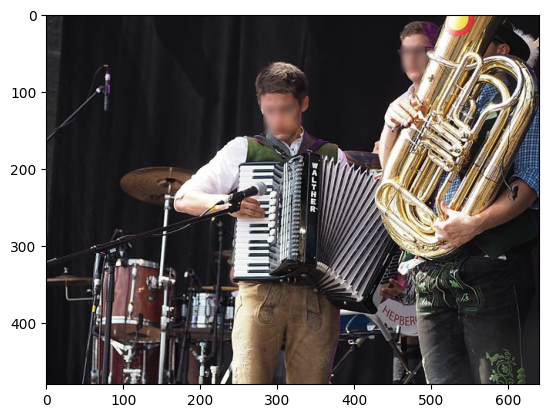

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Image 1 Caption:
한 남자가 키보드와 드럼을 치고 있다


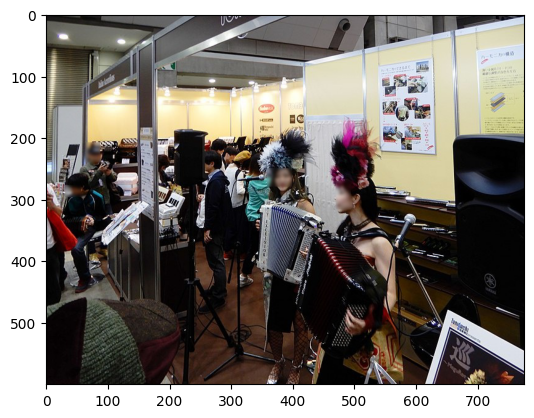

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.30s/it]


Image 2 Caption:
한 무리의 사람들이 악기를 들고 테이블에 서 있다


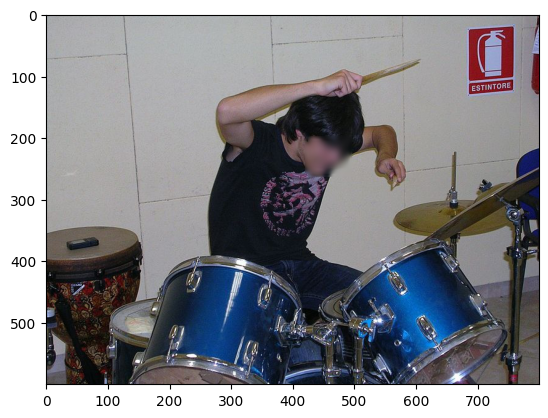

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Image 3 Caption:
한 남자가 드럼을 치면서 음악을 틀고 있다


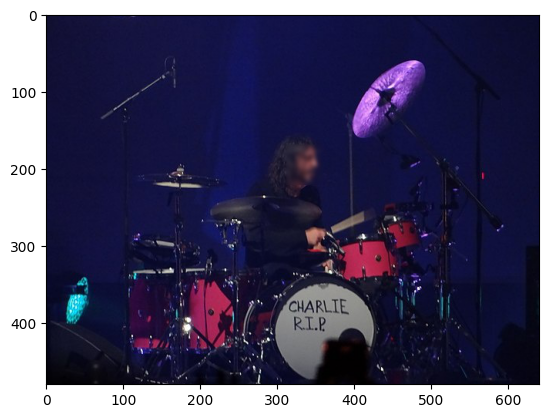

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Image 4 Caption:
드럼을 치는 남자는 그의 앞에 있는 무대에 서 있다


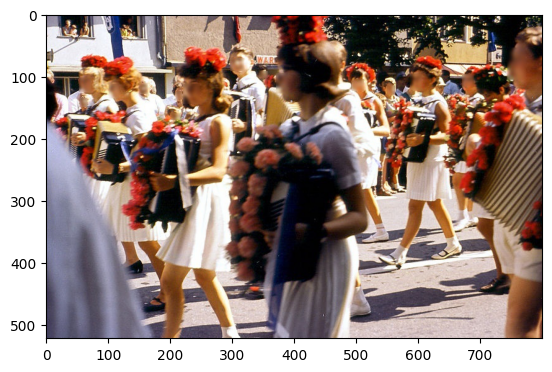

100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]

Image 5 Caption:
한 무리의 사람들이 드레스를 입고 거리를 걸어가고 있다


In [26]:
# CLIP 모델과 GPT 모델을 결합해 이미지에 대한 설명(캡셔닝) 생성

is_gpu = True  # GPU를 사용하려면 True로 설정, CPU를 사용하려면 False로 설정

# use_beam_search를 False로 놓아 Top-p 샘플링 방식으로 캡셔닝 진행
use_beam_search = False
# CLIP 모델 및 GPT2 토크나이저 로드
device = CUDA(0) if is_gpu else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
                          bos_token='</s>', eos_token='</s>', unk_token='<unk>',
                          pad_token='<pad>', mask_token='<mask>')

prefix_length = 10
image_path1= 'Caption_image/110100120220620112135.jpg'
image_path2= 'Caption_image/110100120220620114216.jpg'
image_path3= 'Caption_image/110100520220620163546.jpg'
image_path4= 'Caption_image/110100520220620162411.jpg'
image_path5= 'Caption_image/110100120220620131640.jpg'
def generate_caption(model, tokenizer, image_path, device):
    # 이미지 로드 및 전처리
    image = io.imread(image_path)
    pil_image = PIL.Image.fromarray(image)
    plt.imshow(pil_image)
    plt.show()
    image = preprocess(pil_image).unsqueeze(0).to(device)

    # 이미지 임베딩
    with torch.no_grad():
        prefix = clip_model.encode_image(image).to(device, dtype=torch.float32)
        prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

    # 캡션 생성
    if use_beam_search:
        generated_text = generate_beam(model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text = generate2(model, tokenizer, embed=prefix_embed)

    return generated_text.split('.')[0]

# 하나의 모델로 캡션 생성
model = ClipCaptionModel(prefix_length)
model.load_state_dict(torch.load(model_path, map_location=CPU))
model = model.eval()
device = CUDA(0) if is_gpu else "cpu"
model = model.to(device)

# 첫 번째 이미지에 대한 캡션 생성
caption1 = generate_caption(model, tokenizer, image_path1, device)
print('Image 1 Caption:')
print(caption1)

# 두 번째 이미지에 대한 캡션 생성
caption2 = generate_caption(model, tokenizer, image_path2, device)
print('Image 2 Caption:')
print(caption2)

# 세 번째 이미지에 대한 캡션 생성
caption3 = generate_caption(model, tokenizer, image_path3, device)
print('Image 3 Caption:')
print(caption3)

# 네 번째 이미지에 대한 캡션 생성
caption4 = generate_caption(model, tokenizer, image_path4, device)
print('Image 4 Caption:')
print(caption4)

# 다섯 번째 이미지에 대한 캡션 생성
caption5 = generate_caption(model, tokenizer, image_path5, device)
print('Image 5 Caption:')
print(caption5)



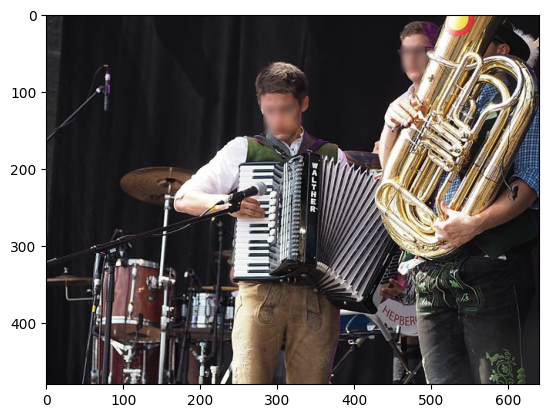

Image 1 Caption:
무대 위에서 키보드와 드럼을 치는 남자


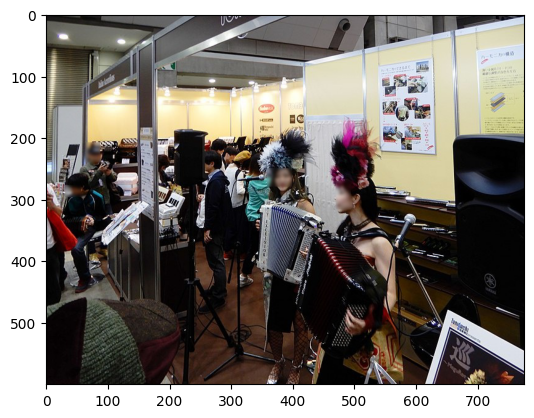

Image 2 Caption:
한 무리의 사람들이 악기를 들고 테이블 주위에 서 있다


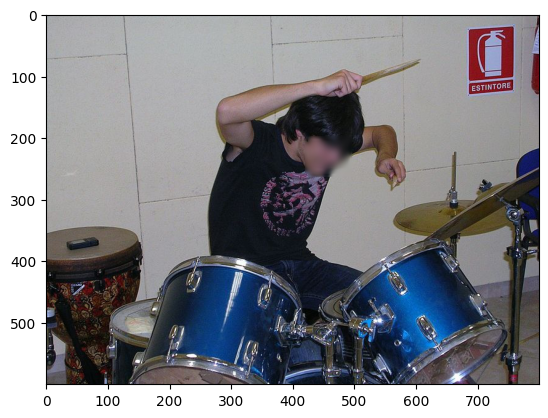

Image 3 Caption:
한 남자가 드럼 세트를 가지고 놀고 있다


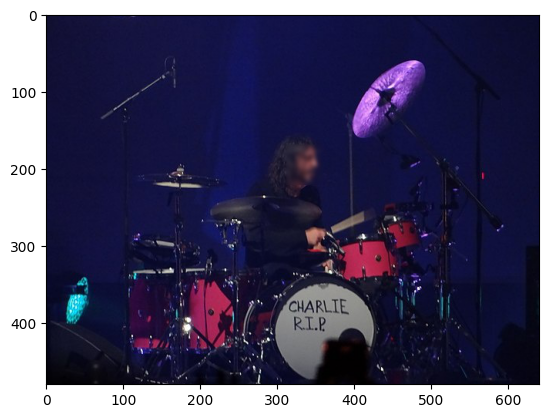

Image 4 Caption:
무대 위에서 드럼을 치고 있는 남자


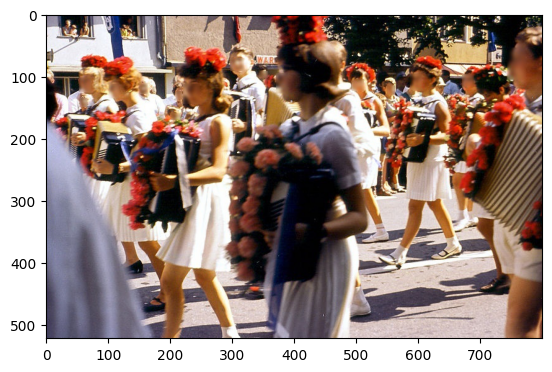

Image 5 Caption:
한 무리의 여자들이 드레스를 입고 길을 걸어가고 있었다


In [27]:
# use_beam_search를 True로 놓아 빔 탐색 알고리즘 사용
use_beam_search =  True


# 첫 번째 이미지에 대한 캡션 생성
caption1 = generate_caption(model, tokenizer, image_path1, device)
print('Image 1 Caption:')
print(caption1)

# 두 번째 이미지에 대한 캡션 생성
caption2 = generate_caption(model, tokenizer, image_path2, device)
print('Image 2 Caption:')
print(caption2)

# 세 번째 이미지에 대한 캡션 생성
caption3 = generate_caption(model, tokenizer, image_path3, device)
print('Image 3 Caption:')
print(caption3)

# 네 번째 이미지에 대한 캡션 생성
caption4 = generate_caption(model, tokenizer, image_path4, device)
print('Image 4 Caption:')
print(caption4)

# 다섯 번째 이미지에 대한 캡션 생성
caption5 = generate_caption(model, tokenizer, image_path5, device)
print('Image 5 Caption:')
print(caption5)

#### 2가지의 방식으로 캡셔닝을 진행 한 결과 둘 다 완벽한 캡션을 하진 못했으나 빔 탐색 알고리즘 방식이 훨씬 자연스러운 결과를 도출한다는 것을 볼 수 있다.

#### 이에 우리는 빔 탐색 알고리즘으로 나머지 캡셔닝을 진행하도록 한다.

In [28]:
#import os
#import json

# # 이미지와 json 파일을 저장할 디렉터리 경로
#image_dir = 'Caption_image'
#output_dir = 'Caption_image_json'

# # 출력 디렉터리가 없으면 생성
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # 이미지 디렉터리에서 모든 이미지 파일을 가져옴
#image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

# # 각 이미지에 대한 캡션 생성
#for image_file in image_files:
#    image_path = os.path.join(image_dir, image_file)
#    caption = generate_caption(model, tokenizer, image_path, device)

#    # 캡션을 json 파일로 저장
#    json_file_path = os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}.json")
#    with open(json_file_path, 'w', encoding='utf-8') as json_file:
#        json.dump({"caption": caption}, json_file, ensure_ascii=False)
